In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn import linear_model
from sklearn.calibration import CalibratedClassifierCV

In [2]:
#mounting the dataset from drive
from google.colab import drive
drive.mount('/content/gdrive') 

#connecting to sqlite db
con = sqlite3.connect('database.sqlite')
                      
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [27]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(100000, 13)


In [28]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

100.0

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [30]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 13)


1    87729
0    12271
Name: Score, dtype: int64

In [31]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]
final['cleanReview'].head()

117924    EVERY book is educational. this witty little b...
117901    This whole series is great way to spend time w...
298792    Entertainingl Funny!. Beetlejuice is a well wr...
169281    A modern day fairy tale. A twist of rumplestis...
298791    FANTASTIC!. Beetlejuice is an excellent and fu...
Name: cleanReview, dtype: object

In [32]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

117924    78
117901    90
298792    31
169281    41
298791    44
Name: lengthOfReview, dtype: int64

In [0]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['Text']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:01<00:00, 313040.89it/s]


In [0]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:01<00:00, 343430.96it/s]


In [0]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [02:16<00:00, 2662.25it/s]


In [0]:
print(len(final['Text']))

364171


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:06<00:00, 53616.87it/s]


In [0]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:30<00:00, 11914.41it/s]


In [0]:
spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [00:20<00:00, 18059.44it/s]


In [0]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [03:37<00:00, 1671.64it/s]


In [0]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'satisfied product advertised use cereal raw vinegar general sweetner'

In [0]:
final['Preprocessed_text'] = preprocessed_reviews

In [0]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview,Preprocessed_text
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,Will not do without. Great for sesame chicken....,30,great sesame chicken good not better resturant...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed. I'm disappointed with the flavor...,47,disappointed flavor chocolate notes especially...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",Perfect for our maltipoo. These stars are smal...,70,stars small give one training session tried tr...
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,Favorite Training and reward treat. These are ...,40,best treats training rewarding dog good groomi...
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...","Great Honey. I am very satisfied ,product is a...",23,satisfied product advertised use cereal raw vi...


In [0]:
dir_path = os.getcwd()
conn = sqlite3.connect(os.path.join(dir_path, '/content/gdrive/My Drive/Colab Notebooks/SVM/final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [4]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [6]:
filtered_data.shape

(364171, 13)

In [0]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [8]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview,Preprocessed_text
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational. this witty little b...,78,witty little book makes son laugh loud recite ...
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,90,remember seeing show aired television years ag...
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny!. Beetlejuice is a well wr...,31,beetlejuice well written movie everything exce...
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale. A twist of rumplestis...,41,twist rumplestiskin captured film starring mic...
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC!. Beetlejuice is an excellent and fu...,44,beetlejuice excellent funny movie keaton hilar...


In [9]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data.head(100000)
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 13 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
Preprocessed_text         364171 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 38.9+ MB
100000


In [10]:
filtered_data['Score'].value_counts()

1    87729
0    12271
Name: Score, dtype: int64

In [11]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    EVERY book is educational. this witty little b...
117901    This whole series is great way to spend time w...
298792    Entertainingl Funny!. Beetlejuice is a well wr...
169281    A modern day fairy tale. A twist of rumplestis...
298791    FANTASTIC!. Beetlejuice is an excellent and fu...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


In [12]:
len(filtered_data['lengthOfReview'])

100000

In [0]:
X_train = X[0:60000]
Y_train = y[0:60000]
X_val = X[60000:80000]
Y_val = y[60000:80000]
X_test = X[80000:100000]
Y_test = y[80000:100000]

In [0]:
print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

60000 20000 20000
60000 20000 20000


# [4.1] BAG OF WORDS

In [0]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(60000, 48270)


In [0]:
X_train_vect.shape

(60000, 48270)

In [0]:
len(final['lengthOfReview'])

364171

In [0]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(final['lengthOfReview'][0:60000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(final['lengthOfReview'][60000:80000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(final['lengthOfReview'][80000:100000])[:,None]))

In [0]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(60000, 48271)
(20000, 48271)
(20000, 48271)


In [0]:
print(len(feature_names))

48270


In [0]:
BoW_dict = {'X_train_vect':concat_data, 'X_test_vect': concat_data_test, 'X_val_vect': concat_data_val}
print(BoW_dict['X_train_vect'].shape)

(60000, 48271)


In [0]:
import pickle
with open('BoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (60000, 61750)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  61750


In [0]:
tfidf_concat_data_train = hstack((train_tf_idf,np.array(final['lengthOfReview'][0:60000])[:,None]))
tfidf_concat_data_val = hstack((cv_tf_idf,np.array(final['lengthOfReview'][60000:80000])[:,None]))
tfidf_concat_data_test = hstack((test_tf_idf,np.array(final['lengthOfReview'][80000:100000])[:,None]))

In [0]:
tf_idf_dict = {'train_tf_idf': tfidf_concat_data_train, 'cv_tf_idf': tfidf_concat_data_val, 'test_tf_idf': tfidf_concat_data_test}

In [0]:
import pickle
with open('tf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sen=[]
for sentance in X_train:
    list_of_sen.append(sentance.split())

In [0]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.8974846005439758), ('fantastic', 0.869934618473053), ('good', 0.8506890535354614), ('terrific', 0.8287807703018188), ('perfect', 0.7907924056053162), ('fabulous', 0.7832920551300049), ('nice', 0.7617159485816956), ('delicious', 0.7552177309989929), ('excellent', 0.7302758097648621), ('great,', 0.7127977609634399)]
[('best', 0.8477296233177185), ('greatest', 0.7988674640655518), ('tastiest', 0.7597992420196533), ('closest', 0.7456486225128174), ('BEST', 0.7329977750778198), ('best-tasting', 0.7289355993270874), ('best.', 0.6994760036468506), ('Best', 0.6785157918930054), ('smoothest', 0.6748092174530029), ('coolest', 0.6651692390441895)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  32552
sample words  ['prunes', 'Good', 'business.', 'pipes', 'couple,', 'crepe', 'Soda,', 'Huckleberry', 'favorites!', 'pleasent', 'marvelous.', '/>Last', 'marriage.', 'missing.', 'courtesy', 'pretzels.', 'chooses', '/>Made', 'heated', 'Primula', 'flossies', 'bones.', 'PowerGel', '"In', 'sparingly', 'since', 'Upon', 'girl.', 'franks', 'oil)', 'cups', 'full-time', '15%', 'had.<br', 'originally', 'certainly', 'enjoying', 'freeze-dried', '1st', "O'clock", 'pronounced.', '64', '"Natural', 'trance', 'mainly', 'topper', '"big', 'figure.', 'Wabash', 'saying']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [0]:
print(X_train[117924])
print(len(X_val))
print(len(X_test))

EVERY book is educational. this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
20000
20000


In [0]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(sentences_received):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences_received): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [0]:
print(len([sent.split() for sent in X_test]))

20000


In [0]:
avg_w2v_train = avg_w2vec([sent.split() for sent in X_train])
avg_w2v_cv = avg_w2vec([sent.split() for sent in X_val])
avg_w2v_test = avg_w2vec([sent.split() for sent in X_test])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [1:26:58<00:00, 11.50it/s]


60000
50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [30:10<00:00, 11.05it/s]


20000
50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [26:46<00:00, 12.45it/s]


20000
50


In [0]:
Avg_w2v_dict = {'X_train_avgw2v':avg_w2v_train, 'Y_train_avgw2v': Y_train,  
                     'X_val_avgw2v': avg_w2v_cv, 'Y_val_avgw2v': Y_val,
                    'X_test_avgw2v': avg_w2v_test, 'Y_test_avgw2v': Y_test}

In [0]:
import pickle
with open('avg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidf_w2v(sentences_received):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(sentences_received): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

In [0]:
tfidf_w2v_train = tfidf_w2v([sent.split() for sent in X_train])
tfidf_w2v_cv = tfidf_w2v([sent.split() for sent in X_val])
tfidf_w2v_test = tfidf_w2v([sent.split() for sent in X_test])

In [0]:
tfidf_w2v_dict = {'X_train_tfidfw2v':tfidf_w2v_train, 'Y_train_tfidfw2v': Y_train,  
                     'X_val_tfidfw2v': tfidf_w2v_cv, 'Y_val_tfidfw2v': Y_val,
                    'X_test_tfidfw2v': tfidf_w2v_test, 'Y_test_tfidfw2v': Y_test}

In [0]:
with open('tfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# SVM on BoW

## [5.1] Linear SVM

In [0]:
import pickle
with open(r"BoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

With L1 Regularizer

In [0]:
#Applying Logistic Regression with L1 regularization on BOW
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

bow_svm_train_score_list = []
bow_svm_val_score_list = []
for a_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]):
    bow_clf = linear_model.SGDClassifier(loss='hinge', penalty='l1', alpha=a_value)
    bow_clf.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_clf_train_score = bow_clf.score(BoW_dict['X_train_vect'], Y_train)
    bow_svm_train_score_list.append(bow_clf_train_score)
    bow_clf_val_score = bow_clf.score(BoW_dict['X_val_vect'], Y_val)
    bow_svm_val_score_list.append(bow_clf_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
bow_train_score = dict(zip(c_all, bow_svm_train_score_list))
bow_val_score = dict(zip(c_all, bow_svm_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.84it/s]


{0.1: 0.8858166666666667, 1: 0.8858166666666667, 100: 0.8858166666666667, 10000: 0.8858166666666667, 1000: 0.8858166666666667, 0.0001: 0.93200000000000005, 10: 0.8858166666666667, 0.01: 0.88591666666666669, 0.001: 0.91011666666666668}
{0.1: 0.86280000000000001, 1: 0.86280000000000001, 100: 0.86280000000000001, 10000: 0.86280000000000001, 1000: 0.86280000000000001, 0.0001: 0.92135, 10: 0.86280000000000001, 0.01: 0.86294999999999999, 0.001: 0.90144999999999997}


With L2 Regularizer

In [0]:
#Applying Logistic Regression with L1 regularization on BOW
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

bow_svm_train_score_list = []
bow_svm_val_score_list = []
for a_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]):
    bow_clf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=a_value)
    bow_clf.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_clf_train_score = bow_clf.score(BoW_dict['X_train_vect'], Y_train)
    bow_svm_train_score_list.append(bow_clf_train_score)
    bow_clf_val_score = bow_clf.score(BoW_dict['X_val_vect'], Y_val)
    bow_svm_val_score_list.append(bow_clf_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
bow_train_score = dict(zip(c_all, bow_svm_train_score_list))
bow_val_score = dict(zip(c_all, bow_svm_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.20it/s]


{0.1: 0.88901666666666668, 1: 0.8858166666666667, 100: 0.8858166666666667, 10000: 0.8858166666666667, 1000: 0.8858166666666667, 0.0001: 0.93269999999999997, 10: 0.8858166666666667, 0.01: 0.93351666666666666, 0.001: 0.93756666666666666}
{0.1: 0.86650000000000005, 1: 0.86280000000000001, 100: 0.86280000000000001, 10000: 0.86280000000000001, 1000: 0.86280000000000001, 0.0001: 0.91725000000000001, 10: 0.86280000000000001, 0.01: 0.91935, 0.001: 0.92505000000000004}


In [0]:
best_a = max(bow_val_score, key=bow_val_score.get)
best_a

0.001

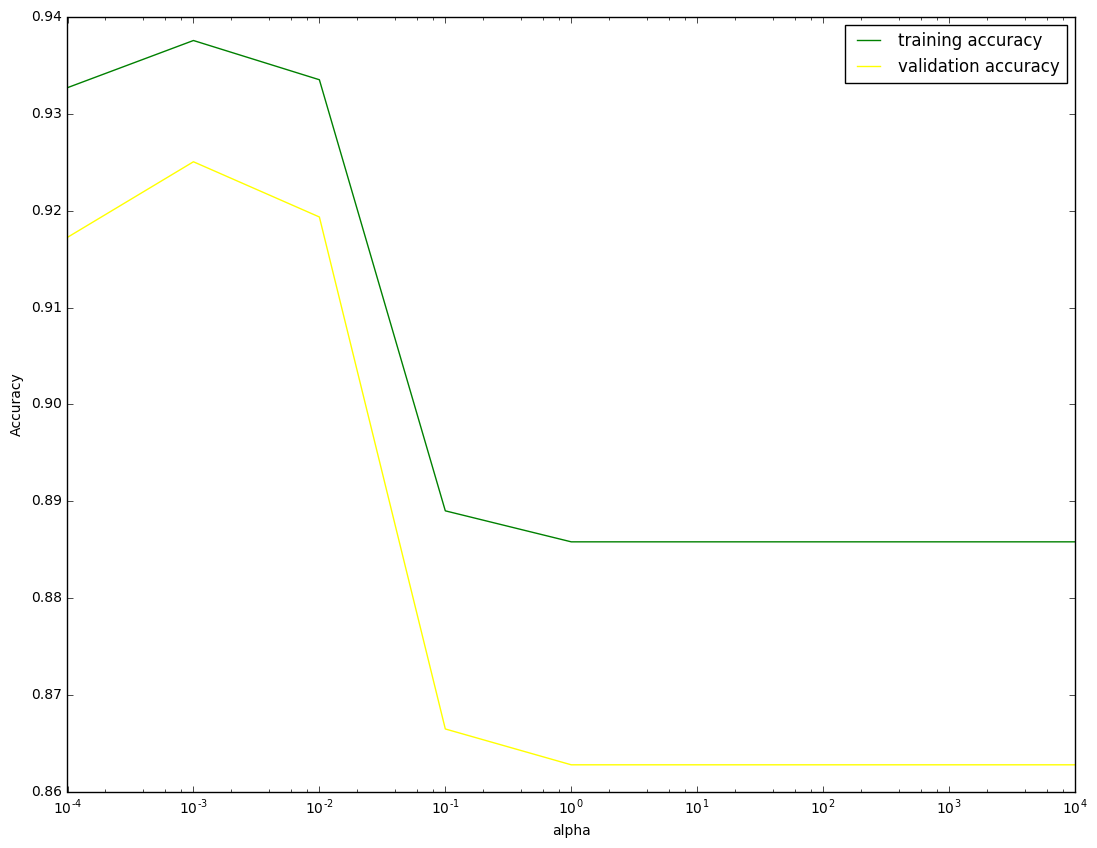

In [0]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, bow_svm_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, bow_svm_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [0]:
bow_svm_linear=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=best_a)
bow_svm_linear.fit(BoW_dict['X_train_vect'],Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(BoW_dict['X_train_vect'],Y_train)
bow_linear_test_proba = f.predict_proba(BoW_dict['X_test_vect'])
bow_linear_train_proba = f.predict_proba(BoW_dict['X_train_vect'])
bow_linear_test_proba

array([[ 0.03997674,  0.96002326],
       [ 0.17785007,  0.82214993],
       [ 0.00545954,  0.99454046],
       ..., 
       [ 0.16841195,  0.83158805],
       [ 0.01552654,  0.98447346],
       [ 0.36460077,  0.63539923]])

In [0]:
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train, bow_linear_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(Y_test, bow_linear_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.904433018262
0.903229718583


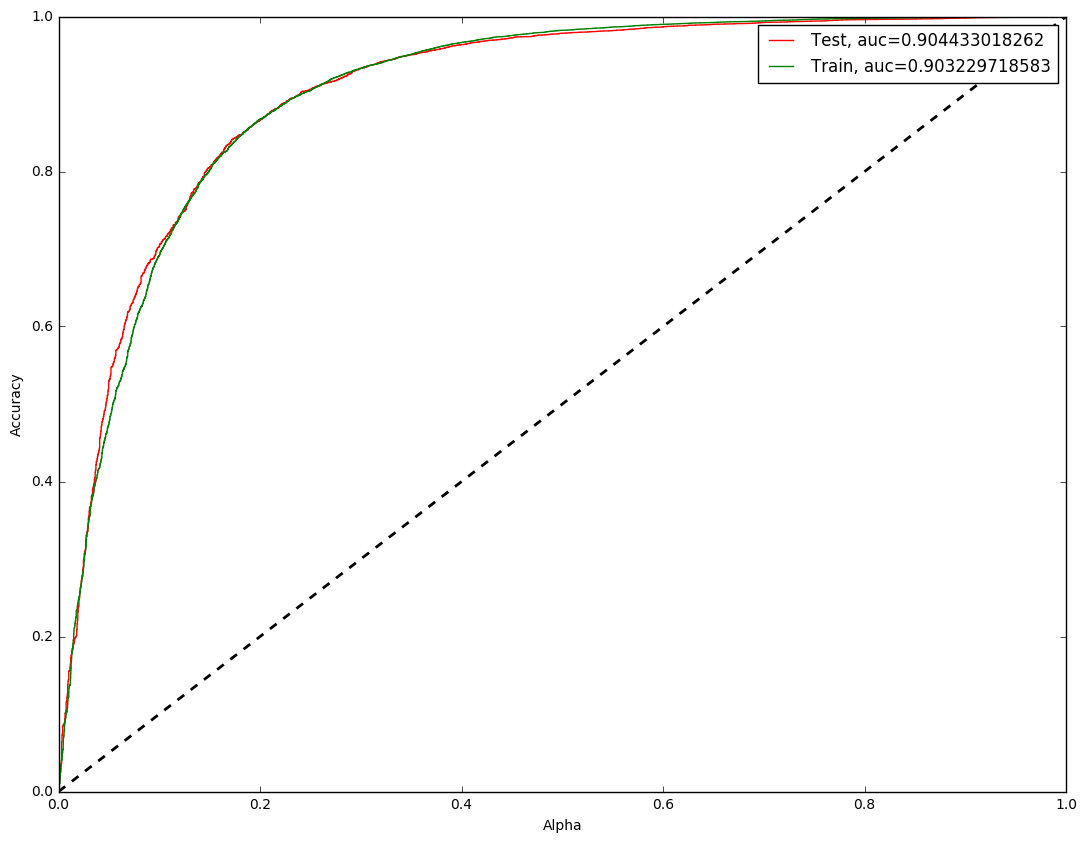

In [0]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(count_vect, bow_svm_linear)

Top 10 featues for negative class 
       Coeff  Labels Negative features
0 -2.844990       0      disappointed
1 -2.025473       0             worst
2 -2.012147       0             money
3 -2.005485       0             awful
4 -1.968840       0          terrible
5 -1.898881       0          horrible
6 -1.625708       0             bland
7 -1.589063       0             stale
8 -1.559081       0     disappointing
9 -1.452477       0               not
Top 10 featues for positive class 
       Coeff  Labels Positive features
0  3.481281       1             great
1  3.251417       1              best
2  3.201446       1         delicious
3  2.648439       1         excellent
4  2.232018       1         wonderful
5  2.188710       1           perfect
6  2.072112       1             loves
7  1.948851       1              nice
8  1.898881       1          favorite
9  1.878893       1             yummy


In [0]:
bow_test_conf = bow_svm_linear.predict(BoW_dict['X_test_vect'])

In [0]:
bow_train_conf = bow_svm_linear.predict(BoW_dict['X_train_vect'])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
bow_train_conf_matrix = confusion_matrix(Y_train, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(Y_test, bow_test_conf)
class_report = classification_report(Y_test, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 1177  1499]
 [  257 17067]]
             precision    recall  f1-score   support

          0       0.82      0.44      0.57      2676
          1       0.92      0.99      0.95     17324

avg / total       0.91      0.91      0.90     20000



[<matplotlib.text.Text at 0x636d26a0>, <matplotlib.text.Text at 0x58fbacf8>]

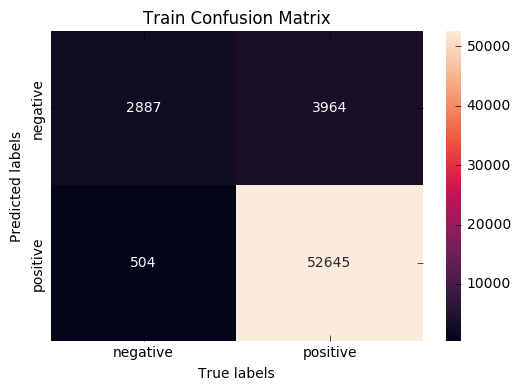

In [0]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x22283128>, <matplotlib.text.Text at 0x78b15da0>]

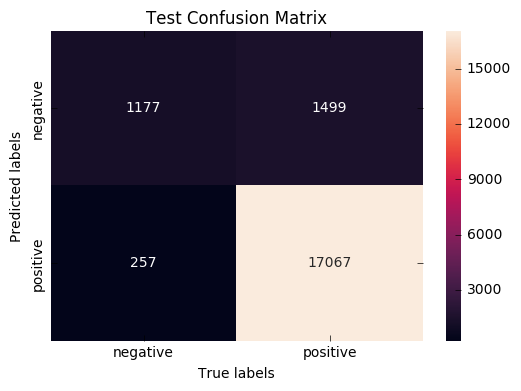

In [0]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on TF-IDF (Linear)

In [0]:
import pickle
with open(r"tf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [0]:
tfidf_svm_train_score_list = []
tfidf_svm_val_score_list = []
for all_a in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]):
    tfidfclf = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=all_a)
    tfidfclf.fit(tfidf_dict['train_tf_idf'],Y_train)
    
    tfidf_svm_train_score = tfidfclf.score(tfidf_dict['train_tf_idf'], Y_train)
    tfidf_svm_train_score_list.append(tfidf_svm_train_score)
    tfidf_svm_val_score = tfidfclf.score(tfidf_dict['cv_tf_idf'], Y_val)
    tfidf_svm_val_score_list.append(tfidf_svm_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
tfidf_train_score = dict(zip(c_all, tfidf_svm_train_score_list))
tfidf_val_scores = dict(zip(c_all, tfidf_svm_val_score_list))
print(tfidf_train_score)
print(tfidf_val_scores)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.77it/s]


{0.1: 0.8858166666666667, 1: 0.8858166666666667, 100: 0.8858166666666667, 10000: 0.8858166666666667, 1000: 0.8858166666666667, 0.0001: 0.88754999999999995, 10: 0.8858166666666667, 0.01: 0.8858166666666667, 0.001: 0.11625000000000001}
{0.1: 0.86280000000000001, 1: 0.86280000000000001, 100: 0.86280000000000001, 10000: 0.86280000000000001, 1000: 0.86280000000000001, 0.0001: 0.86475000000000002, 10: 0.86280000000000001, 0.01: 0.86280000000000001, 0.001: 0.13865}


In [0]:
tfidf_best_a = max(tfidf_val_scores, key=tfidf_val_scores.get)
tfidf_best_a

0.0001

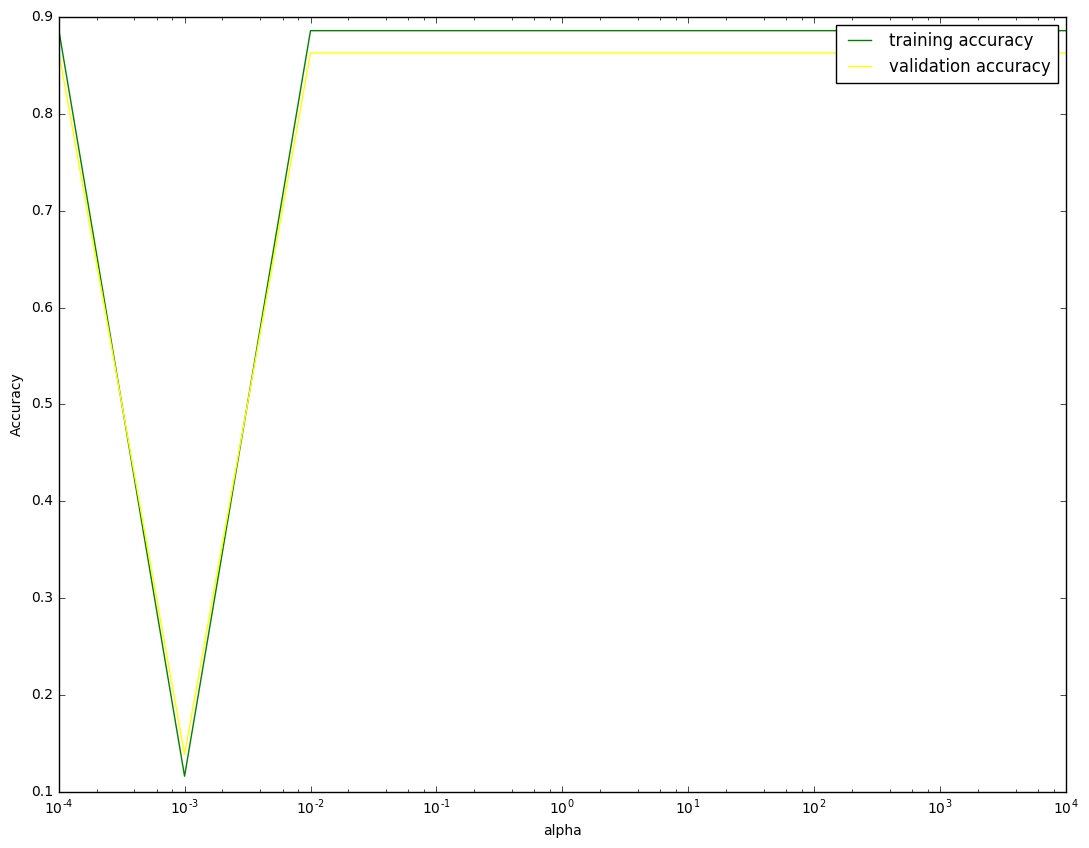

In [0]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, tfidf_svm_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidf_svm_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [0]:
tfidf_svm_linear=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=best_a)
tfidf_svm_linear.fit(tfidf_dict['train_tf_idf'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(tfidf_dict['train_tf_idf'], Y_train)
tfidf_linear_test_proba = f.predict_proba(tfidf_dict['test_tf_idf'])
tfidf_linear_train_proba = f.predict_proba(tfidf_dict['train_tf_idf'])
tfidf_linear_test_proba

array([[ 0.11354938,  0.88645062],
       [ 0.11459146,  0.88540854],
       [ 0.11413437,  0.88586563],
       ..., 
       [ 0.11368474,  0.88631526],
       [ 0.11330243,  0.88669757],
       [ 0.11423827,  0.88576173]])

In [0]:
#https://stackoverflow.com/questions/26976362/how-to-get-most-informative-features-for-scikit-learn-classifier-for-different-c
neg_features_labels = []
neg_features_coeff = []
neg_features_feat = []

pos_features_labels = []
pos_features_coeff = []
pos_features_feat = []
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        neg_features_labels.append(class_labels[0])
        neg_features_coeff.append(coef)
        neg_features_feat.append(feat)
    
    for coef, feat in reversed(topn_class2):
        pos_features_labels.append(class_labels[1])
        pos_features_coeff.append(coef)
        pos_features_feat.append(feat)
        
    neg_df = pd.DataFrame({'Labels': neg_features_labels,'Coeff':neg_features_coeff ,'Negative features':neg_features_feat})
    pos_df = pd.DataFrame({'Labels': pos_features_labels,'Coeff':pos_features_coeff ,'Positive features':pos_features_feat})
    print("Top 10 featues for negative class \n", neg_df)
    print("Top 10 featues for positive class \n", pos_df)
    
f = most_informative_feature_for_binary_classification(tf_idf_vect, tfidf_svm_linear)

Top 10 featues for negative class 
       Coeff  Labels Negative features
0 -2.707195       0               not
1 -0.901843       0               bad
2 -0.887087       0      disappointed
3 -0.830637       0             would
4 -0.750159       0             money
5 -0.684442       0           not buy
6 -0.650887       0             awful
7 -0.632034       0         would not
8 -0.629365       0          terrible
9 -0.616957       0          not good
Top 10 featues for positive class 
       Coeff  Labels Positive features
0  2.165727       1             great
1  1.433100       1              best
2  1.146839       1              love
3  1.036500       1              good
4  1.017636       1         delicious
5  1.008281       1               tea
6  0.792217       1         excellent
7  0.682033       1         wonderful
8  0.673267       1          favorite
9  0.634391       1           perfect


In [0]:
tfidf_fpr_train, tfidf_tpr_train, _ = roc_curve(Y_train, tfidf_linear_train_proba[:, 1])
tfidf_fpr_test, tfidf_tpr_test, _ = roc_curve(Y_test, tfidf_linear_test_proba[:, 1])
tfidf_test_auc = auc(tfidf_fpr_test, tfidf_tpr_test)
tfidf_train_auc = auc(tfidf_fpr_train, tfidf_tpr_train)
print(tfidf_test_auc)
print(tfidf_train_auc)

0.768314018
0.764797568203


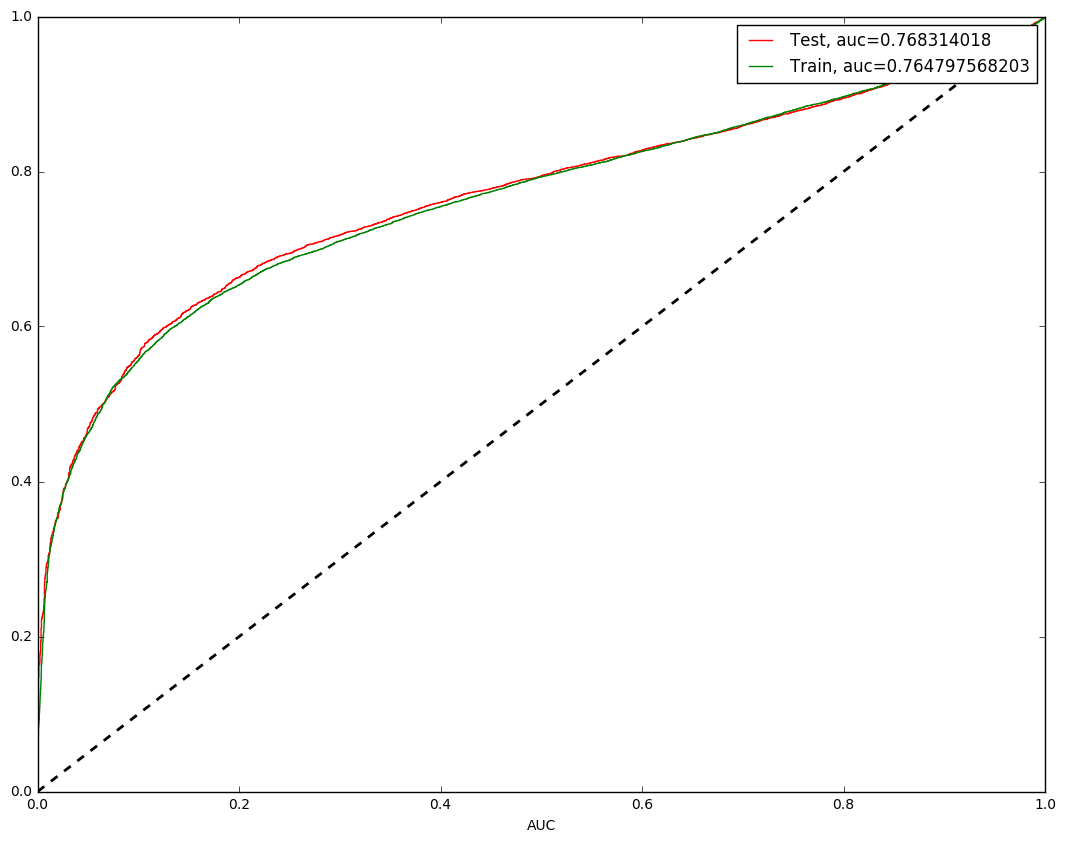

In [0]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidf_fpr_test, tfidf_tpr_test, label="Test, auc="+str(tfidf_test_auc), color = 'red')
plt.plot(tfidf_fpr_train, tfidf_tpr_train, label="Train, auc="+str(tfidf_train_auc), color = 'green')

plt.xlabel('AUC')
plt.legend()

plt.show()

In [0]:
tfidf_test_conf = tfidf_svm_linear.predict(tfidf_dict['test_tf_idf'])

In [0]:
tfidf_train_conf = tfidf_svm_linear.predict(tfidf_dict['train_tf_idf'])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
tfidf_test_conf_matrix = confusion_matrix(Y_test, tfidf_test_conf)
tfidf_train_conf_matrix = confusion_matrix(Y_train, tfidf_train_conf)
class_report = classification_report(Y_test, tfidf_test_conf)
print(tfidf_test_conf_matrix)
print(class_report)

[[  191  2485]
 [   26 17298]]
             precision    recall  f1-score   support

          0       0.88      0.07      0.13      2676
          1       0.87      1.00      0.93     17324

avg / total       0.88      0.87      0.83     20000



[<matplotlib.text.Text at 0x34406f60>, <matplotlib.text.Text at 0x694dd0b8>]

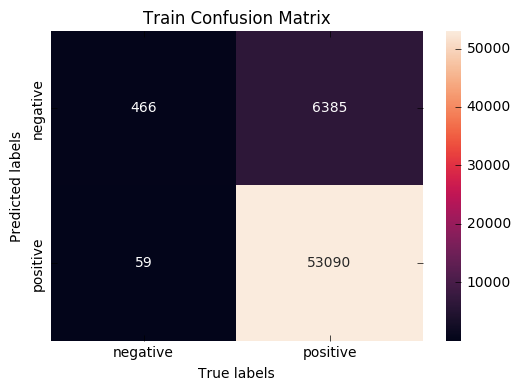

In [0]:
ax= plt.subplot()
sns.heatmap(tfidf_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x36d304a8>, <matplotlib.text.Text at 0x32146668>]

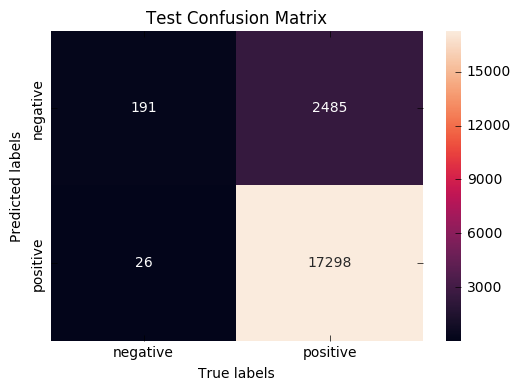

In [0]:
ax= plt.subplot()
sns.heatmap(tfidf_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on Avg-W2V

In [0]:
import pickle
with open(r"avg_w2v.pkl", "rb") as input_file:
    avg_tfidf_dict = pickle.load(input_file)

In [0]:
avg_lgr_train_score_list = []
avg_lgr_val_score_list = []
for a_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    avg_lgr=linear_model.SGDClassifier(loss='hinge', penalty='l1', alpha=a_value)
    avg_lgr.fit(avg_tfidf_dict['X_train_avgw2v'],Y_train)
    
    avg_lgr_train_score = avg_lgr.score(avg_tfidf_dict['X_train_avgw2v'], Y_train)
    avg_lgr_train_score_list.append(avg_lgr_train_score)
    avg_lgr_val_score = avg_lgr.score(avg_tfidf_dict['X_val_avgw2v'], Y_val)
    avg_lgr_val_score_list.append(avg_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
avg_train_score = dict(zip(c_all, avg_lgr_train_score_list))
avg_val_score = dict(zip(c_all, avg_lgr_val_score_list))
print(avg_train_score)
print(avg_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.35it/s]


{0.1: 0.8858166666666667, 1: 0.8858166666666667, 100: 0.8858166666666667, 10000: 0.8858166666666667, 1000: 0.8858166666666667, 0.0001: 0.91368333333333329, 10: 0.8858166666666667, 0.01: 0.8858166666666667, 0.001: 0.91536666666666666}
{0.1: 0.86280000000000001, 1: 0.86280000000000001, 100: 0.86280000000000001, 10000: 0.86280000000000001, 1000: 0.86280000000000001, 0.0001: 0.89854999999999996, 10: 0.86280000000000001, 0.01: 0.86280000000000001, 0.001: 0.90325}


In [0]:
best_a = max(avg_val_score, key=avg_val_score.get)
best_a

0.001

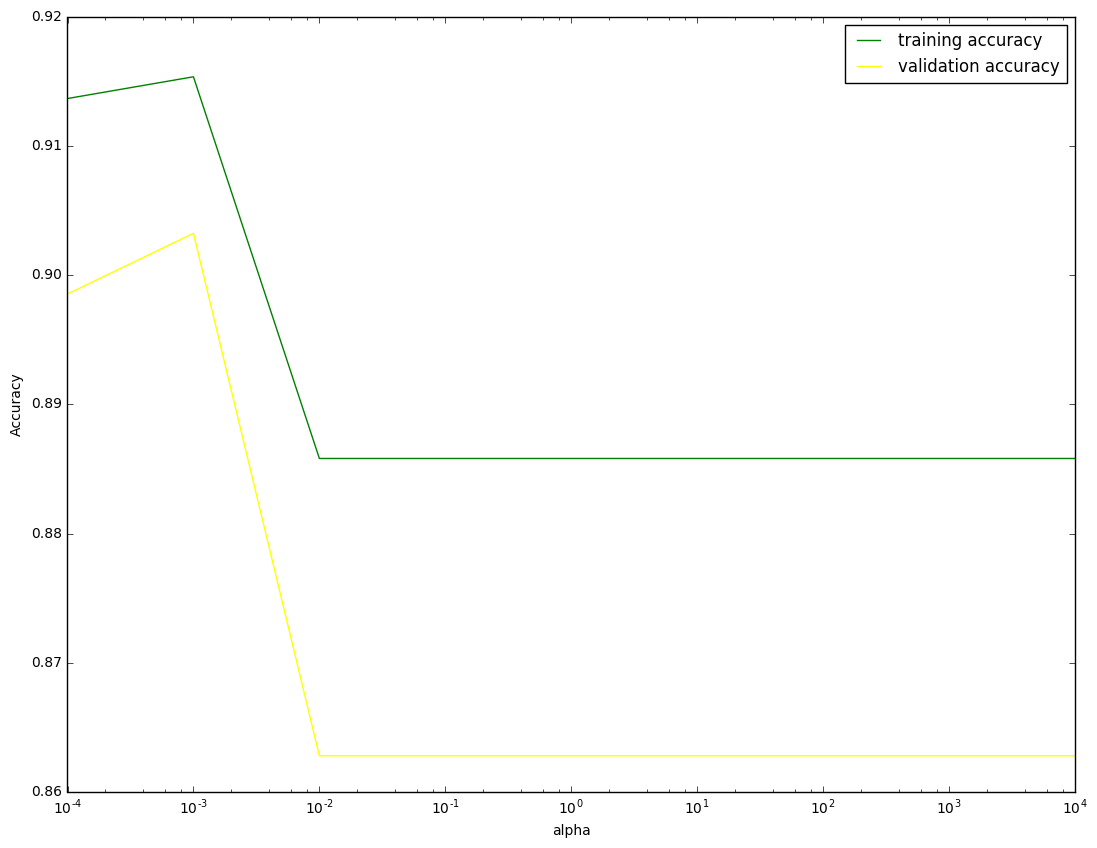

In [0]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, avg_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, avg_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [0]:
avg_svm_linear=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=best_a)
avg_svm_linear.fit(avg_tfidf_dict['X_train_avgw2v'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(avg_tfidf_dict['X_train_avgw2v'], Y_train)
avg_linear_test_proba = f.predict_proba(avg_tfidf_dict['X_test_avgw2v'])
avg_linear_train_proba = f.predict_proba(avg_tfidf_dict['X_train_avgw2v'])
avg_linear_test_proba

array([[  1.93320313e-03,   9.98066797e-01],
       [  8.58651105e-01,   1.41348895e-01],
       [  2.10185104e-02,   9.78981490e-01],
       ..., 
       [  1.21741529e-01,   8.78258471e-01],
       [  8.67555402e-06,   9.99991324e-01],
       [  1.91983420e-01,   8.08016580e-01]])

In [0]:
avg_fpr_train, avg_tpr_train, _ = roc_curve(Y_train, avg_linear_train_proba[:, 1])
avg_fpr_test, avg_tpr_test, _ = roc_curve(Y_test, avg_linear_test_proba[:, 1])
avg_test_auc = auc(avg_fpr_test, avg_tpr_test)
avg_train_auc = auc(avg_fpr_train, avg_tpr_train)
print(avg_test_auc)
print(avg_train_auc)

0.924123003539
0.921497149929


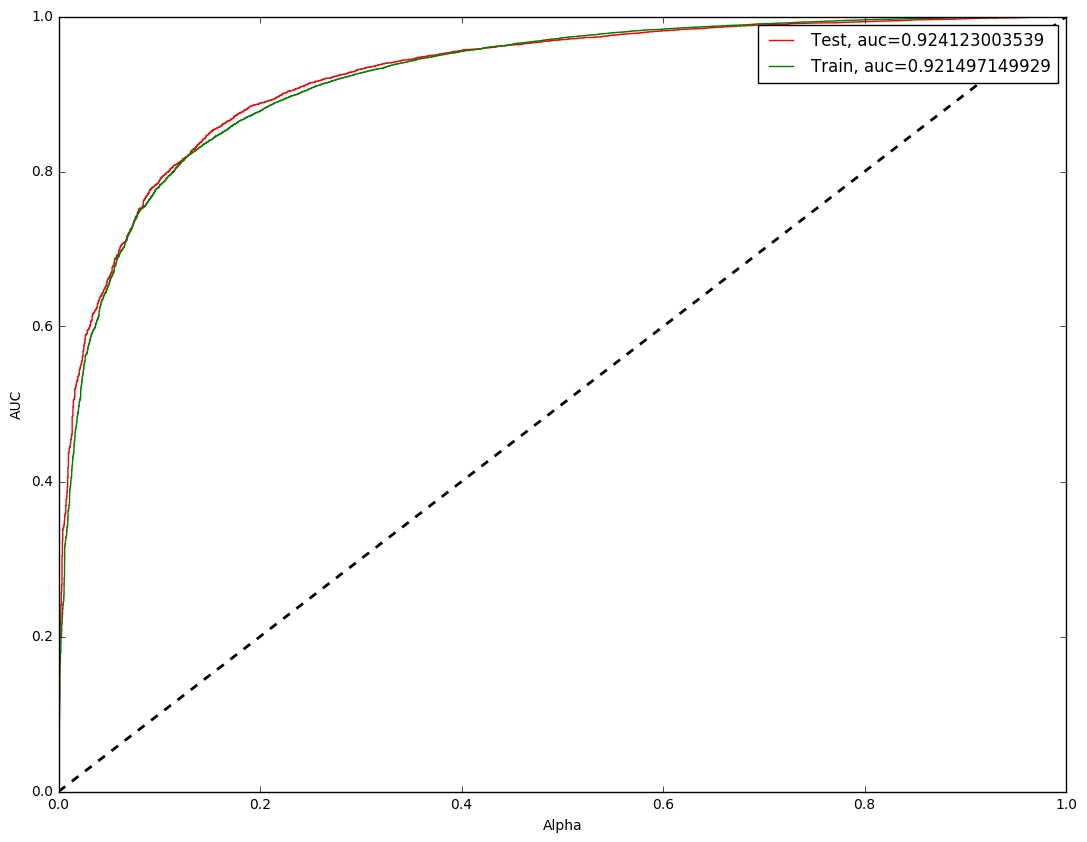

In [0]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(avg_fpr_test, avg_tpr_test, label="Test, auc="+str(avg_test_auc), color = 'red')
plt.plot(avg_fpr_train, avg_tpr_train, label="Train, auc="+str(avg_train_auc), color = 'green')

plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [0]:
avg_test_conf = avg_svm_linear.predict(avg_tfidf_dict['X_test_avgw2v'])
avg_train_conf = avg_svm_linear.predict(avg_tfidf_dict['X_train_avgw2v'])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
avg_test_conf_matrix = confusion_matrix(Y_test, avg_test_conf)
avg_train_conf_matrix = confusion_matrix(Y_train, avg_train_conf)
class_report = classification_report(Y_test, avg_test_conf)
print(avg_test_conf_matrix)
print(class_report)

[[  807  1869]
 [  205 17119]]
             precision    recall  f1-score   support

          0       0.80      0.30      0.44      2676
          1       0.90      0.99      0.94     17324

avg / total       0.89      0.90      0.88     20000



[<matplotlib.text.Text at 0x3a8491d0>, <matplotlib.text.Text at 0x42418630>]

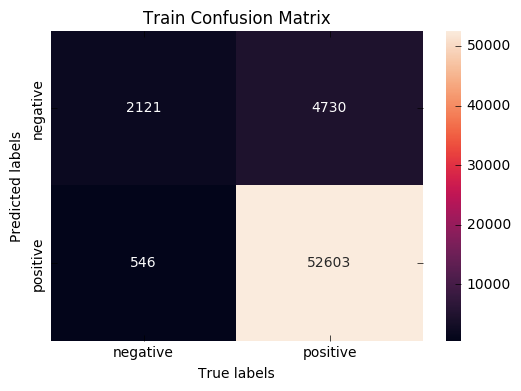

In [0]:
ax= plt.subplot()
sns.heatmap(avg_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x2a4c0da0>, <matplotlib.text.Text at 0x71a02ba8>]

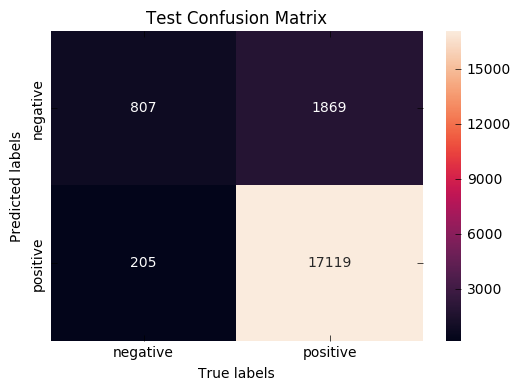

In [0]:
ax= plt.subplot()
sns.heatmap(avg_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on tfidf_w2v

In [0]:
import pickle
with open(r"tfidf_w2v.pkl", "rb") as input_file:
    tfidfw2v_dict = pickle.load(input_file)

In [0]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

tfidfw2v_lgr_train_score_list = []
tfidfw2v_lgr_val_score_list = []
for a_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    tfidfw2v_lgr=linear_model.SGDClassifier(loss='hinge', penalty='l1', alpha=a_value)
    tfidfw2v_lgr.fit(tfidfw2v_dict['X_train_tfidfw2v'],Y_train)
    
    tfidfw2v_lgr_train_score = tfidfw2v_lgr.score(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
    tfidfw2v_lgr_train_score_list.append(tfidfw2v_lgr_train_score)
    tfidfw2v_lgr_val_score = tfidfw2v_lgr.score(tfidfw2v_dict['X_val_tfidfw2v'], Y_val)
    tfidfw2v_lgr_val_score_list.append(tfidfw2v_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
tfidfw2v_train_score = dict(zip(c_all, tfidfw2v_lgr_train_score_list))
tfidfw2v_val_score = dict(zip(c_all, tfidfw2v_lgr_val_score_list))
print(tfidfw2v_train_score)
print(tfidfw2v_val_score)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.19it/s]


{0.1: 0.8858166666666667, 1: 0.8858166666666667, 100: 0.8858166666666667, 10000: 0.8858166666666667, 1000: 0.8858166666666667, 0.0001: 0.89253333333333329, 10: 0.8858166666666667, 0.01: 0.8858166666666667, 0.001: 0.89581666666666671}
{0.1: 0.86280000000000001, 1: 0.86280000000000001, 100: 0.86280000000000001, 10000: 0.86280000000000001, 1000: 0.86280000000000001, 0.0001: 0.87190000000000001, 10: 0.86280000000000001, 0.01: 0.86280000000000001, 0.001: 0.87609999999999999}


In [0]:
best_a = max(tfidfw2v_val_score, key=tfidfw2v_val_score.get)
best_a

0.001

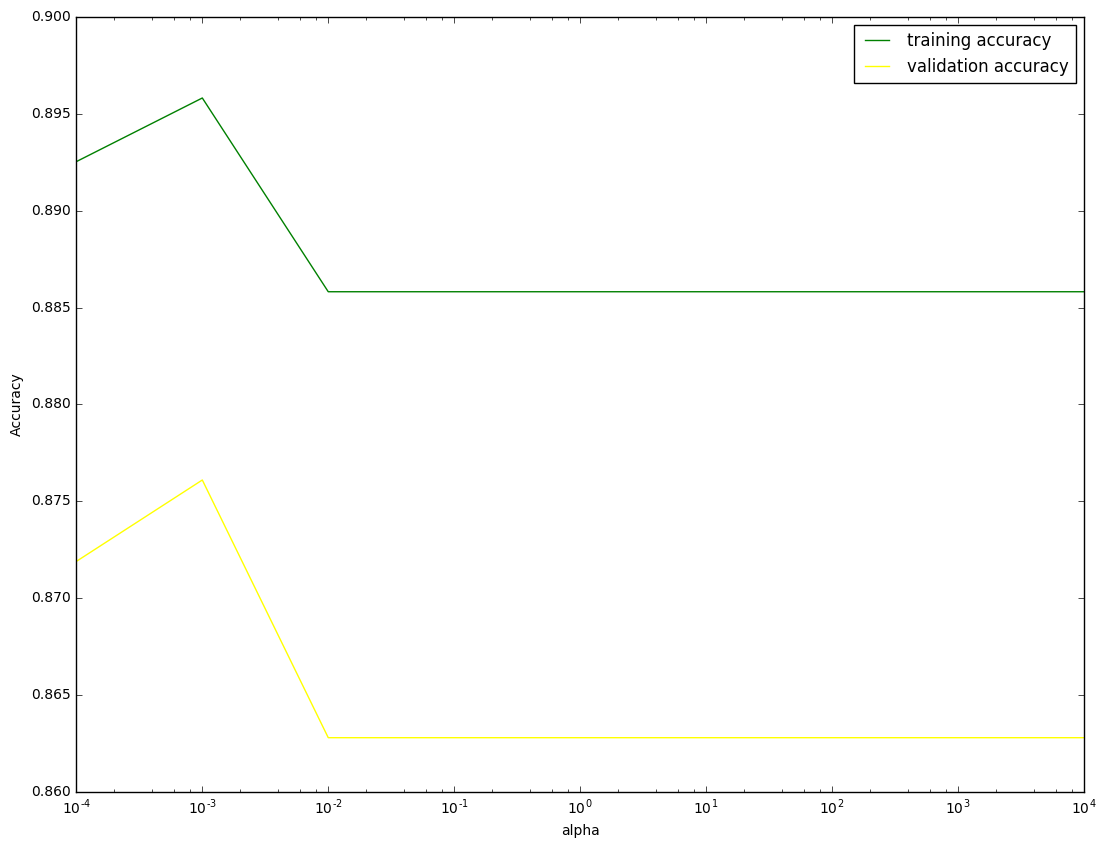

In [0]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, tfidfw2v_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidfw2v_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [0]:
tfidfw2v_svm_linear=linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=best_a)
tfidfw2v_svm_linear.fit(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
tfidfw2v_test_proba = f.predict_proba(tfidfw2v_dict['X_test_tfidfw2v'])
tfidfw2v_train_proba = f.predict_proba(tfidfw2v_dict['X_train_tfidfw2v'])
tfidfw2v_test_proba

array([[  5.67270863e-02,   9.43272914e-01],
       [  6.19355514e-01,   3.80644486e-01],
       [  1.62112882e-02,   9.83788712e-01],
       ..., 
       [  1.35165571e-01,   8.64834429e-01],
       [  5.30136402e-04,   9.99469864e-01],
       [  2.91473317e-01,   7.08526683e-01]])

In [0]:
tfidfw2v_fpr_train, tfidfw2v_tpr_train, _ = roc_curve(Y_train, tfidfw2v_train_proba[:, 1])
tfidfw2v_fpr_test, tfidfw2v_tpr_test, _ = roc_curve(Y_test, tfidfw2v_test_proba[:, 1])
tfidfw2v_test_auc = auc(tfidfw2v_fpr_test, tfidfw2v_tpr_test)
tfidfw2v_train_auc = auc(tfidfw2v_fpr_train, tfidfw2v_tpr_train)
print(tfidfw2v_test_auc)
print(tfidfw2v_train_auc)

0.895609245354
0.893375311895


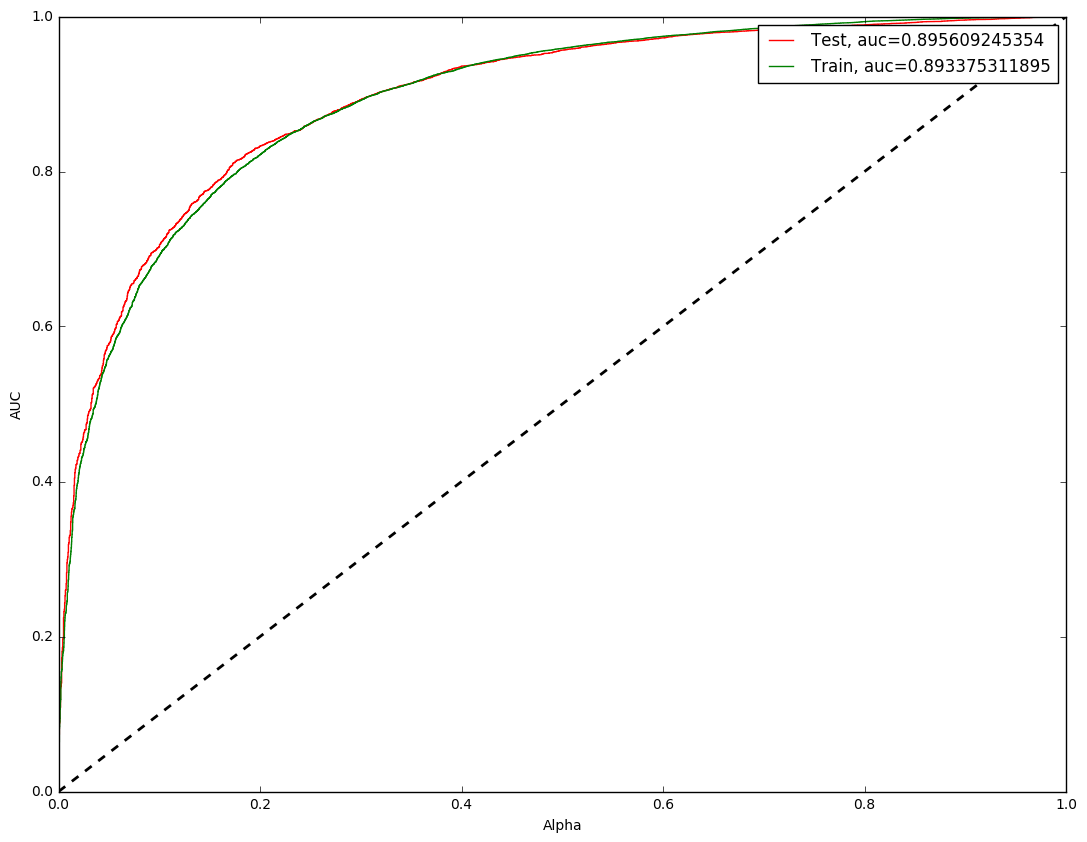

In [0]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidfw2v_fpr_test, tfidfw2v_tpr_test, label="Test, auc="+str(tfidfw2v_test_auc), color = 'red')
plt.plot(tfidfw2v_fpr_train, tfidfw2v_tpr_train, label="Train, auc="+str(tfidfw2v_train_auc), color = 'green')

plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [0]:
tfidfw2v_test_conf = tfidfw2v_svm_linear.predict(tfidfw2v_dict['X_test_tfidfw2v'])
tfidfw2v_train_conf = tfidfw2v_svm_linear.predict(tfidfw2v_dict['X_train_tfidfw2v'])

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
tfidfw2v_test_conf_matrix = confusion_matrix(Y_test, tfidfw2v_test_conf)
tfidfw2v_train_conf_matrix = confusion_matrix(Y_train, tfidfw2v_train_conf)
class_report = classification_report(Y_test, tfidfw2v_test_conf)
print(tfidfw2v_train_conf_matrix)
print(class_report)

[[ 1409  5442]
 [  417 52732]]
             precision    recall  f1-score   support

          0       0.73      0.19      0.30      2676
          1       0.89      0.99      0.94     17324

avg / total       0.87      0.88      0.85     20000



[<matplotlib.text.Text at 0x403af1d0>, <matplotlib.text.Text at 0xd798ef0>]

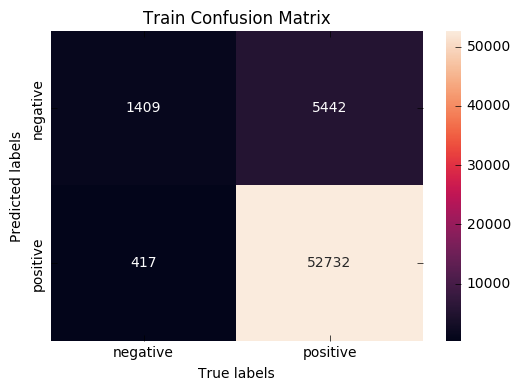

In [0]:
ax= plt.subplot()
sns.heatmap(tfidfw2v_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[<matplotlib.text.Text at 0x3dfd7940>, <matplotlib.text.Text at 0x343f8d30>]

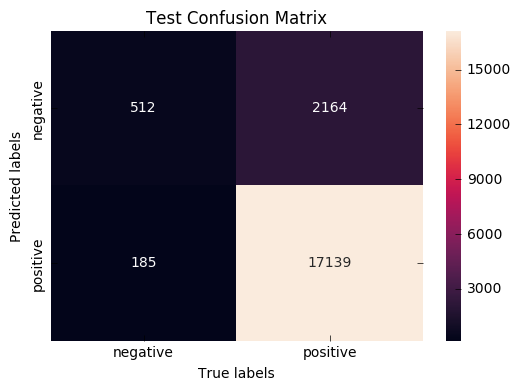

In [0]:
ax= plt.subplot()
sns.heatmap(tfidfw2v_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# RBF Kernel

In [0]:
#Data

X_train = X[0:20000]
Y_train = y[0:20000]
X_val = X[20000:25000]
Y_val = y[20000:25000]
X_test = X[25000:30000]
Y_test = y[25000:30000]

In [15]:
print(len(X_train), len(X_test), len(X_val))
print(len(Y_train), len(Y_test), len(Y_val))

20000 5000 5000
20000 5000 5000


# BoW on 20k 

In [33]:
from sklearn.feature_extraction.text import CountVectorizer 

count_vect = CountVectorizer()
X_train_vect = count_vect.fit_transform(X_train)
X_test_vect = count_vect.transform(X_test)
X_val_vect = count_vect.transform(X_val)
feature_names = count_vect.get_feature_names()
# BoW_dict = {'X_train_vect':X_train_vect, 'X_test_vect': X_test_vect, 'X_val_vect': X_val_vect}
print(X_train_vect.shape)
# print(feature_names)

(20000, 29706)


In [0]:
from scipy.sparse import hstack
# len_review = final['lengthOfReview'].to_sparse()
concat_data = hstack((X_train_vect,np.array(final['lengthOfReview'][0:20000])[:,None]))
concat_data_val = hstack((X_val_vect,np.array(final['lengthOfReview'][20000:25000])[:,None]))
concat_data_test = hstack((X_test_vect,np.array(final['lengthOfReview'][25000:30000])[:,None]))

In [36]:
print(concat_data.shape)
print(concat_data_val.shape)
print(concat_data_test.shape)

(20000, 29707)
(5000, 29707)
(5000, 29707)


In [37]:
BoW_dict = {'X_train_vect':concat_data, 'X_test_vect': concat_data_test, 'X_val_vect': concat_data_val}
print(BoW_dict['X_train_vect'].shape)

(20000, 29707)


In [0]:
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/SVM/30kBoW.pkl', 'wb') as handle:
    pickle.dump(BoW_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.3] TF-IDF

In [39]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
train_tf_idf = tf_idf_vect.fit_transform(X_train)
cv_tf_idf = tf_idf_vect.transform(X_val)
test_tf_idf = tf_idf_vect.transform(X_test)

print("the shape of out text TFIDF vectorizer ",train_tf_idf.get_shape())
print("the type of count vectorizer ",type(train_tf_idf))
print("the number of unique words including both unigrams and bigrams ", train_tf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (20000, 500)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the number of unique words including both unigrams and bigrams  500


In [0]:
tfidf_concat_data_train = hstack((train_tf_idf,np.array(final['lengthOfReview'][0:20000])[:,None]))
tfidf_concat_data_val = hstack((cv_tf_idf,np.array(final['lengthOfReview'][20000:25000])[:,None]))
tfidf_concat_data_test = hstack((test_tf_idf,np.array(final['lengthOfReview'][25000:30000])[:,None]))

In [0]:
tf_idf_dict = {'train_tf_idf': tfidf_concat_data_train, 'cv_tf_idf': tfidf_concat_data_val, 'test_tf_idf': tfidf_concat_data_test}

In [0]:
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/SVM/30ktf_idf.pkl', 'wb') as handle:
    pickle.dump(tf_idf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sen=[]
for sentance in X_train:
    list_of_sen.append(sentance.split())

In [17]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.9070028066635132), ('good', 0.8153142929077148), ('perfect', 0.7934567332267761), ('nice', 0.7591120600700378), ('fantastic', 0.7322080731391907), ('delicious', 0.7165140509605408), ('special', 0.6991521120071411), ('excellent', 0.6706159710884094), ('decent', 0.6646473407745361), ('great.', 0.6598770022392273)]
[('best.', 0.8320965766906738), ('best', 0.8228322267532349), ('best-tasting', 0.8215420842170715), ('nicest', 0.810248076915741), ('greatest', 0.7961810231208801), ('best!', 0.7789650559425354), ('had.', 0.7666232585906982), ('Best', 0.7660649418830872), ('tried.', 0.7629457116127014), ('made.', 0.759280800819397)]


In [18]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16103
sample words  ['EVERY', 'book', 'is', 'this', 'little', 'makes', 'my', 'son', 'laugh', 'at', 'i', 'it', 'in', 'the', 'car', 'as', "we're", 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', "he's", 'learned', 'about', 'India,', 'love', 'all', 'new', 'words', 'of', 'all.', 'a', 'classic', 'am', 'willing', 'to', 'bet', 'will', 'STILL', 'be', 'able', 'from', 'memory', 'when', 'college', 'This', 'whole']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

# [4.4.1.1] Avg W2v

In [19]:
print(X_train[117924])
print(len(X_val))
print(len(X_test))

EVERY book is educational. this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
5000
5000


In [0]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2vec(sentences_received):
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(sentences_received): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

In [21]:
print(len([sent.split() for sent in X_test]))

5000


In [22]:
avg_w2v_train = avg_w2vec([sent.split() for sent in X_train])
avg_w2v_cv = avg_w2vec([sent.split() for sent in X_val])
avg_w2v_test = avg_w2vec([sent.split() for sent in X_test])

  1%|          | 28/5000 [00:00<00:17, 276.46it/s]

20000
50


  0%|          | 25/5000 [00:00<00:20, 247.93it/s]

5000
50


100%|██████████| 5000/5000 [00:30<00:00, 165.08it/s]

5000
50


In [0]:
Avg_w2v_dict = {'X_train_avgw2v':avg_w2v_train, 'Y_train_avgw2v': Y_train,  
                     'X_val_avgw2v': avg_w2v_cv, 'Y_val_avgw2v': Y_val,
                    'X_test_avgw2v': avg_w2v_test, 'Y_test_avgw2v': Y_test}

In [0]:
import pickle
with open('/content/gdrive/My Drive/Colab Notebooks/SVM/30kavg_w2v.pkl', 'wb') as handle:
    pickle.dump(Avg_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# TFIDF-w2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def tfidf_w2v(sentences_received):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(sentences_received): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        
    return tfidf_sent_vectors

In [46]:
tfidf_w2v_train = tfidf_w2v([sent.split() for sent in X_train])
tfidf_w2v_cv = tfidf_w2v([sent.split() for sent in X_val])
tfidf_w2v_test = tfidf_w2v([sent.split() for sent in X_test])

100%|██████████| 5000/5000 [00:34<00:00, 145.98it/s]


In [0]:
tfidf_w2v_dict = {'X_train_tfidfw2v':tfidf_w2v_train, 'Y_train_tfidfw2v': Y_train,  
                     'X_val_tfidfw2v': tfidf_w2v_cv, 'Y_val_tfidfw2v': Y_val,
                    'X_test_tfidfw2v': tfidf_w2v_test, 'Y_test_tfidfw2v': Y_test}

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/SVM/30ktfidf_w2v.pkl', 'wb') as handle:
    pickle.dump(tfidf_w2v_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# SVM on BoW (RBF)

In [0]:
from sklearn.svm import SVC

In [0]:
import pickle
with open(r"/content/gdrive/My Drive/Colab Notebooks/SVM/30kBoW.pkl", "rb") as input_file:
    BoW_dict = pickle.load(input_file)

In [51]:
#Applying Logistic Regression with L1 regularization on BOW
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

bow_svm_train_score_list = []
bow_svm_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]):
    bow_clf = SVC(C=c_value, kernel='rbf')
    bow_clf.fit(BoW_dict['X_train_vect'],Y_train)
    
    bow_clf_train_score = bow_clf.score(BoW_dict['X_train_vect'], Y_train)
    bow_svm_train_score_list.append(bow_clf_train_score)
    bow_clf_val_score = bow_clf.score(BoW_dict['X_val_vect'], Y_val)
    bow_svm_val_score_list.append(bow_clf_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
bow_train_score = dict(zip(c_all, bow_svm_train_score_list))
bow_val_score = dict(zip(c_all, bow_svm_val_score_list))
print(bow_train_score)
print(bow_val_score)

100%|██████████| 9/9 [21:20<00:00, 151.09s/it]

{0.0001: 0.89135, 0.001: 0.89135, 0.01: 0.89135, 0.1: 0.89135, 1: 0.89145, 10: 0.89185, 100: 0.9479, 1000: 0.9857, 10000: 0.9857}
{0.0001: 0.8834, 0.001: 0.8834, 0.01: 0.8834, 0.1: 0.8834, 1: 0.8834, 10: 0.8834, 100: 0.9238, 1000: 0.9362, 10000: 0.9362}


In [52]:
best_c = max(bow_val_score, key=bow_val_score.get)
best_c

1000

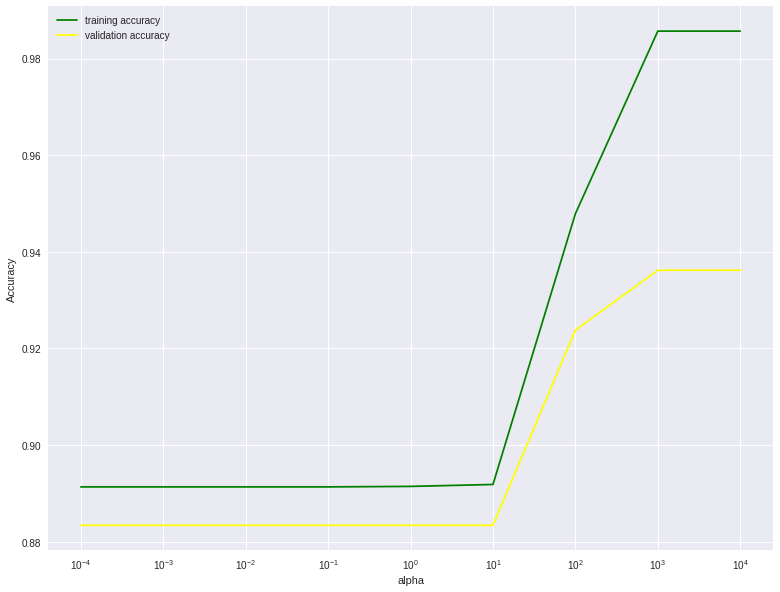

In [53]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, bow_svm_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, bow_svm_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [54]:
bow_svm_linear=SVC(C=best_c, kernel='rbf')
bow_svm_linear.fit(BoW_dict['X_train_vect'],Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(BoW_dict['X_train_vect'],Y_train)
bow_linear_test_proba = f.predict_proba(BoW_dict['X_test_vect'])
bow_linear_train_proba = f.predict_proba(BoW_dict['X_train_vect'])
bow_linear_test_proba

array([[0.1148381 , 0.8851619 ],
       [0.05897012, 0.94102988],
       [0.03864145, 0.96135855],
       ...,
       [0.02261815, 0.97738185],
       [0.02777235, 0.97222765],
       [0.1101549 , 0.8898451 ]])

In [55]:
bow_fpr_train, bow_tpr_train, _ = roc_curve(Y_train, bow_linear_train_proba[:, 1])
bow_fpr_test, bow_tpr_test, _ = roc_curve(Y_test, bow_linear_test_proba[:, 1])
bow_test_auc = auc(bow_fpr_test, bow_tpr_test)
bow_train_auc = auc(bow_fpr_train, bow_tpr_train)
print(bow_test_auc)
print(bow_train_auc)

0.9547278842215279
0.9925751078312599


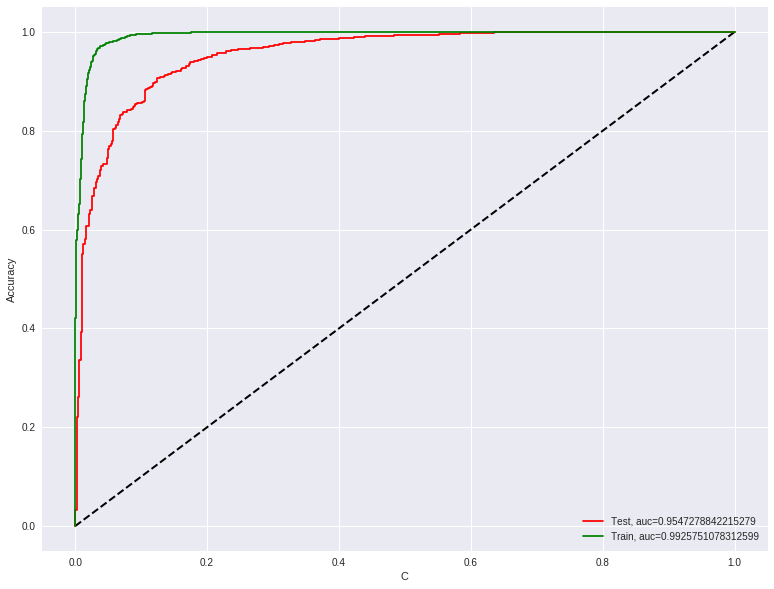

In [56]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(bow_fpr_test, bow_tpr_test, label="Test, auc="+str(bow_test_auc), color = 'red')
plt.plot(bow_fpr_train, bow_tpr_train, label="Train, auc="+str(bow_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
bow_test_conf = bow_svm_linear.predict(BoW_dict['X_test_vect'])

In [0]:
bow_train_conf = bow_svm_linear.predict(BoW_dict['X_train_vect'])

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
bow_train_conf_matrix = confusion_matrix(Y_train, bow_train_conf)
bow_test_conf_matrix = confusion_matrix(Y_test, bow_test_conf)
class_report = classification_report(Y_test, bow_test_conf)
print(bow_test_conf_matrix)
print(class_report)

[[ 300  182]
 [  78 4440]]
              precision    recall  f1-score   support

           0       0.79      0.62      0.70       482
           1       0.96      0.98      0.97      4518

   micro avg       0.95      0.95      0.95      5000
   macro avg       0.88      0.80      0.83      5000
weighted avg       0.94      0.95      0.95      5000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

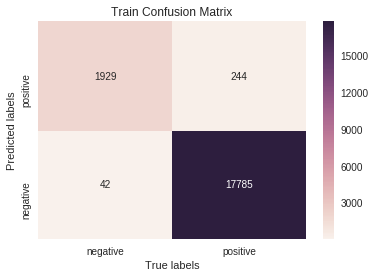

In [61]:
ax= plt.subplot()
sns.heatmap(bow_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

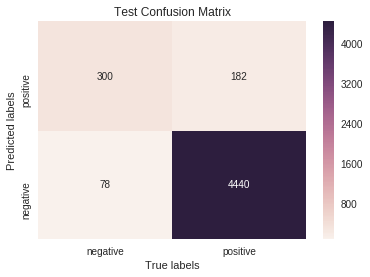

In [62]:
ax= plt.subplot()
sns.heatmap(bow_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on TF-IDF (Linear)

In [0]:
import pickle
with open(r"/content/gdrive/My Drive/Colab Notebooks/SVM/30ktf_idf.pkl", "rb") as input_file:
    tfidf_dict = pickle.load(input_file)

In [65]:
tfidf_svm_train_score_list = []
tfidf_svm_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1000]):
    tfidfclf = SVC(C=c_value, kernel='rbf')
    tfidfclf.fit(tfidf_dict['train_tf_idf'],Y_train)
    
    tfidf_svm_train_score = tfidfclf.score(tfidf_dict['train_tf_idf'], Y_train)
    tfidf_svm_train_score_list.append(tfidf_svm_train_score)
    tfidf_svm_val_score = tfidfclf.score(tfidf_dict['cv_tf_idf'], Y_val)
    tfidf_svm_val_score_list.append(tfidf_svm_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
tfidf_train_score = dict(zip(c_all, tfidf_svm_train_score_list))
tfidf_val_scores = dict(zip(c_all, tfidf_svm_val_score_list))
print(tfidf_train_score)
print(tfidf_val_scores)

100%|██████████| 9/9 [20:08<00:00, 158.74s/it]

{0.0001: 0.89135, 0.001: 0.89135, 0.01: 0.89135, 0.1: 0.89135, 1: 0.8915, 10: 0.8915, 100: 0.91225, 1000: 0.96535, 10000: 0.96535}
{0.0001: 0.8834, 0.001: 0.8834, 0.01: 0.8834, 0.1: 0.8834, 1: 0.8834, 10: 0.8834, 100: 0.8954, 1000: 0.907, 10000: 0.907}


In [66]:
tfidf_best_c = max(tfidf_val_scores, key=tfidf_val_scores.get)
tfidf_best_c

1000

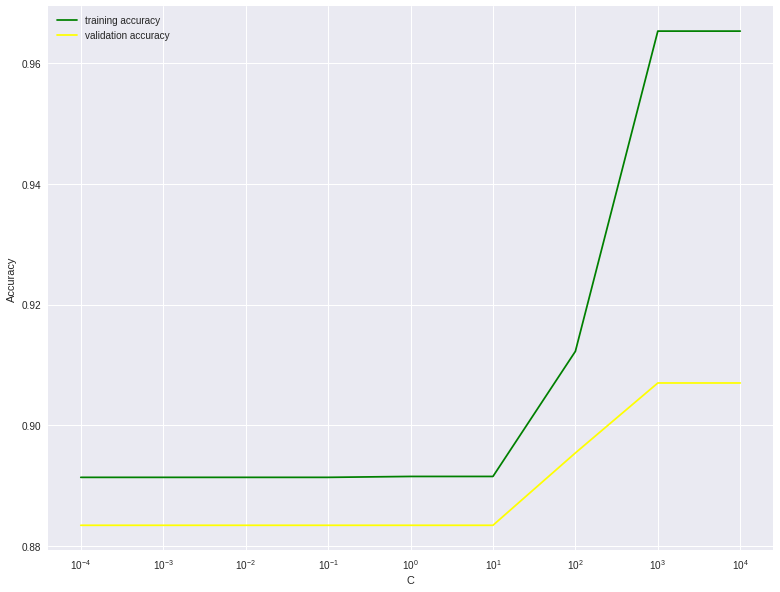

In [67]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, tfidf_svm_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidf_svm_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [69]:
tfidf_svm_linear=SVC(C=tfidf_best_c, kernel='rbf')
tfidf_svm_linear.fit(tfidf_dict['train_tf_idf'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(tfidf_dict['train_tf_idf'], Y_train)
tfidf_linear_test_proba = f.predict_proba(tfidf_dict['test_tf_idf'])
tfidf_linear_train_proba = f.predict_proba(tfidf_dict['train_tf_idf'])
tfidf_linear_test_proba

array([[0.06192611, 0.93807389],
       [0.05750108, 0.94249892],
       [0.09716267, 0.90283733],
       ...,
       [0.06753958, 0.93246042],
       [0.01556645, 0.98443355],
       [0.13025602, 0.86974398]])

In [70]:
tfidf_fpr_train, tfidf_tpr_train, _ = roc_curve(Y_train, tfidf_linear_train_proba[:, 1])
tfidf_fpr_test, tfidf_tpr_test, _ = roc_curve(Y_test, tfidf_linear_test_proba[:, 1])
tfidf_test_auc = auc(tfidf_fpr_test, tfidf_tpr_test)
tfidf_train_auc = auc(tfidf_fpr_train, tfidf_tpr_train)
print(tfidf_test_auc)
print(tfidf_train_auc)

0.9030085283577538
0.9760537895653092


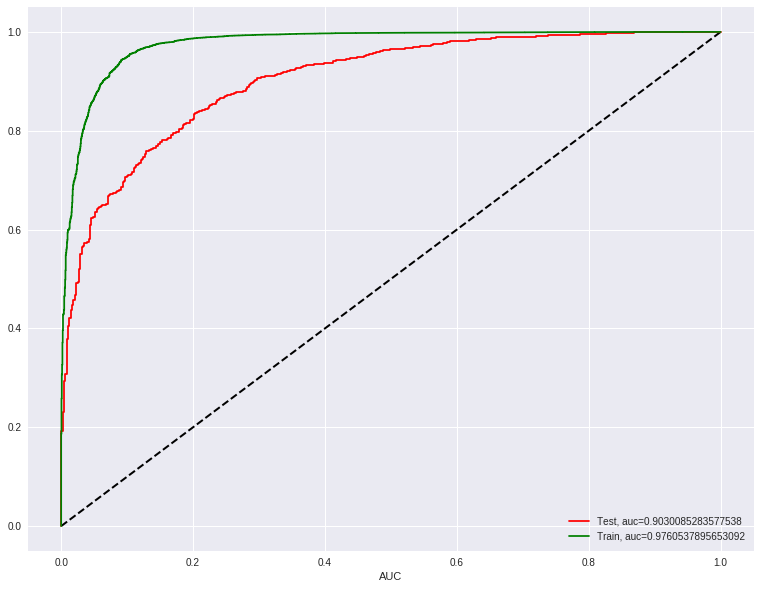

In [71]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidf_fpr_test, tfidf_tpr_test, label="Test, auc="+str(tfidf_test_auc), color = 'red')
plt.plot(tfidf_fpr_train, tfidf_tpr_train, label="Train, auc="+str(tfidf_train_auc), color = 'green')

plt.xlabel('AUC')
plt.legend()

plt.show()

In [0]:
tfidf_test_conf = tfidf_svm_linear.predict(tfidf_dict['test_tf_idf'])

In [0]:
tfidf_train_conf = tfidf_svm_linear.predict(tfidf_dict['train_tf_idf'])

In [74]:
from sklearn.metrics import classification_report, confusion_matrix
tfidf_test_conf_matrix = confusion_matrix(Y_test, tfidf_test_conf)
tfidf_train_conf_matrix = confusion_matrix(Y_train, tfidf_train_conf)
class_report = classification_report(Y_test, tfidf_test_conf)
print(tfidf_test_conf_matrix)
print(class_report)

[[ 200  282]
 [ 127 4391]]
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       482
           1       0.94      0.97      0.96      4518

   micro avg       0.92      0.92      0.92      5000
   macro avg       0.78      0.69      0.72      5000
weighted avg       0.91      0.92      0.91      5000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

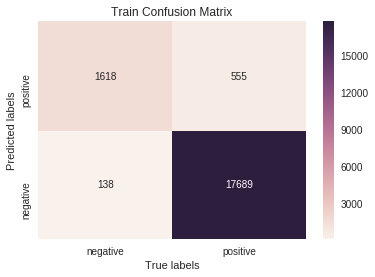

In [75]:
ax= plt.subplot()
sns.heatmap(tfidf_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

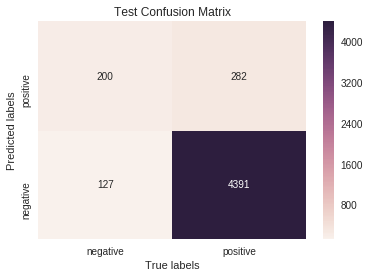

In [76]:
ax= plt.subplot()
sns.heatmap(tfidf_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on Avg-W2V

In [0]:
import pickle
with open(r"/content/gdrive/My Drive/Colab Notebooks/SVM/30kavg_w2v.pkl", "rb") as input_file:
    avg_tfidf_dict = pickle.load(input_file)

In [79]:
avg_lgr_train_score_list = []
avg_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    avg_lgr=SVC(C=c_value, kernel='rbf')
    avg_lgr.fit(avg_tfidf_dict['X_train_avgw2v'],Y_train)
    
    avg_lgr_train_score = avg_lgr.score(avg_tfidf_dict['X_train_avgw2v'], Y_train)
    avg_lgr_train_score_list.append(avg_lgr_train_score)
    avg_lgr_val_score = avg_lgr.score(avg_tfidf_dict['X_val_avgw2v'], Y_val)
    avg_lgr_val_score_list.append(avg_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
avg_train_score = dict(zip(c_all, avg_lgr_train_score_list))
avg_val_score = dict(zip(c_all, avg_lgr_val_score_list))
print(avg_train_score)
print(avg_val_score)

100%|██████████| 9/9 [14:28<00:00, 207.91s/it]

{0.0001: 0.89135, 0.001: 0.89135, 0.01: 0.89135, 0.1: 0.89135, 1: 0.89135, 10: 0.89375, 100: 0.91015, 1000: 0.9316, 10000: 0.9604}
{0.0001: 0.8834, 0.001: 0.8834, 0.01: 0.8834, 0.1: 0.8834, 1: 0.8834, 10: 0.8858, 100: 0.894, 1000: 0.8948, 10000: 0.8818}


In [85]:
best_c = max(avg_val_score, key=avg_val_score.get)
best_c

1000

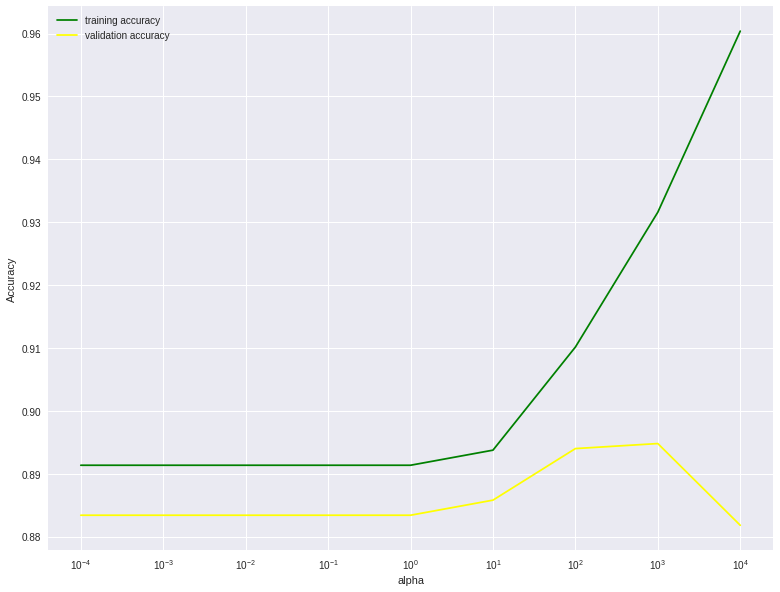

In [86]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, avg_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, avg_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [87]:
avg_svm_linear=SVC(C=best_c, kernel='rbf')
avg_svm_linear.fit(avg_tfidf_dict['X_train_avgw2v'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(avg_tfidf_dict['X_train_avgw2v'], Y_train)
avg_linear_test_proba = f.predict_proba(avg_tfidf_dict['X_test_avgw2v'])
avg_linear_train_proba = f.predict_proba(avg_tfidf_dict['X_train_avgw2v'])
avg_linear_test_proba

array([[0.08696042, 0.91303958],
       [0.19738614, 0.80261386],
       [0.31957795, 0.68042205],
       ...,
       [0.06537385, 0.93462615],
       [0.05504791, 0.94495209],
       [0.09057401, 0.90942599]])

In [88]:
avg_fpr_train, avg_tpr_train, _ = roc_curve(Y_train, avg_linear_train_proba[:, 1])
avg_fpr_test, avg_tpr_test, _ = roc_curve(Y_test, avg_linear_test_proba[:, 1])
avg_test_auc = auc(avg_fpr_test, avg_tpr_test)
avg_train_auc = auc(avg_fpr_train, avg_tpr_train)
print(avg_test_auc)
print(avg_train_auc)

0.8683807875919098
0.936986124063844


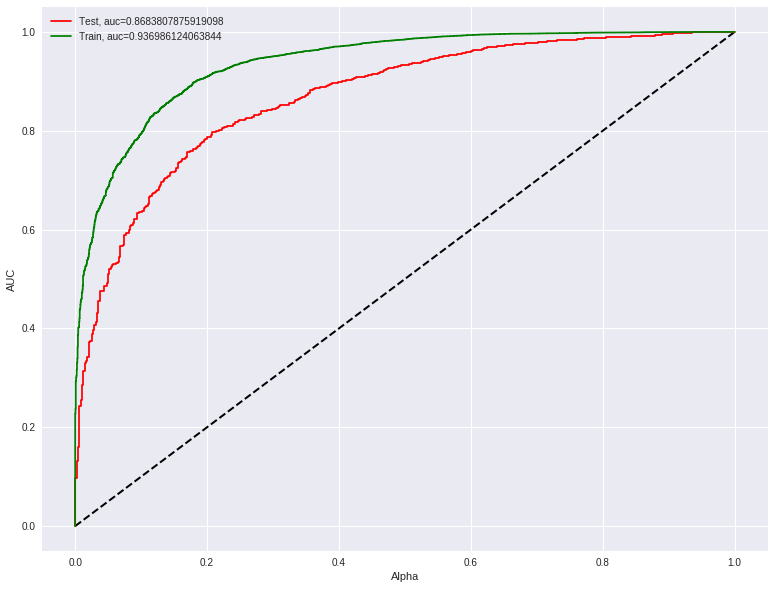

In [89]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(avg_fpr_test, avg_tpr_test, label="Test, auc="+str(avg_test_auc), color = 'red')
plt.plot(avg_fpr_train, avg_tpr_train, label="Train, auc="+str(avg_train_auc), color = 'green')

plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.legend()

plt.show()

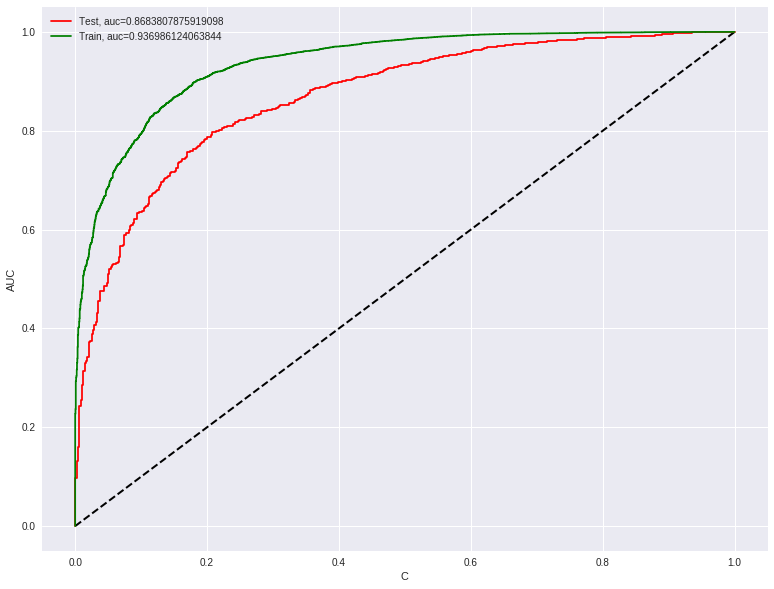

In [91]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(avg_fpr_test, avg_tpr_test, label="Test, auc="+str(avg_test_auc), color = 'red')
plt.plot(avg_fpr_train, avg_tpr_train, label="Train, auc="+str(avg_train_auc), color = 'green')

plt.xlabel('C')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [0]:
avg_test_conf = avg_svm_linear.predict(avg_tfidf_dict['X_test_avgw2v'])
avg_train_conf = avg_svm_linear.predict(avg_tfidf_dict['X_train_avgw2v'])

In [93]:
from sklearn.metrics import classification_report, confusion_matrix
avg_test_conf_matrix = confusion_matrix(Y_test, avg_test_conf)
avg_train_conf_matrix = confusion_matrix(Y_train, avg_train_conf)
class_report = classification_report(Y_test, avg_test_conf)
print(avg_test_conf_matrix)
print(class_report)

[[ 132  350]
 [  89 4429]]
              precision    recall  f1-score   support

           0       0.60      0.27      0.38       482
           1       0.93      0.98      0.95      4518

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.76      0.63      0.66      5000
weighted avg       0.90      0.91      0.90      5000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

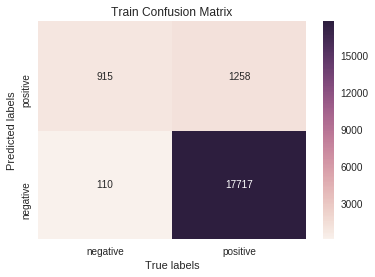

In [94]:
ax= plt.subplot()
sns.heatmap(avg_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

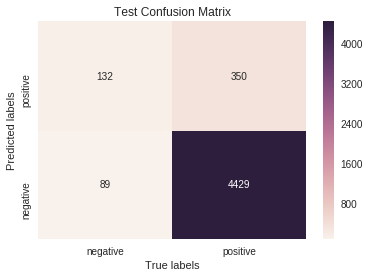

In [95]:
ax= plt.subplot()
sns.heatmap(avg_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

# SVM on tfidf_w2v (RBF)

In [0]:
import pickle
with open(r"/content/gdrive/My Drive/Colab Notebooks/SVM/30ktfidf_w2v.pkl", "rb") as input_file:
    tfidfw2v_dict = pickle.load(input_file)

In [98]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

tfidfw2v_lgr_train_score_list = []
tfidfw2v_lgr_val_score_list = []
for c_value in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]):
    tfidfw2v_lgr=SVC(C=c_value, kernel='rbf')
    tfidfw2v_lgr.fit(tfidfw2v_dict['X_train_tfidfw2v'],Y_train)
    
    tfidfw2v_lgr_train_score = tfidfw2v_lgr.score(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
    tfidfw2v_lgr_train_score_list.append(tfidfw2v_lgr_train_score)
    tfidfw2v_lgr_val_score = tfidfw2v_lgr.score(tfidfw2v_dict['X_val_tfidfw2v'], Y_val)
    tfidfw2v_lgr_val_score_list.append(tfidfw2v_lgr_val_score)

c_all = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
tfidfw2v_train_score = dict(zip(c_all, tfidfw2v_lgr_train_score_list))
tfidfw2v_val_score = dict(zip(c_all, tfidfw2v_lgr_val_score_list))
print(tfidfw2v_train_score)
print(tfidfw2v_val_score)

100%|██████████| 9/9 [18:45<00:00, 261.07s/it]

{0.0001: 0.89135, 0.001: 0.89135, 0.01: 0.89135, 0.1: 0.89135, 1: 0.89135, 10: 0.895, 100: 0.92135, 1000: 0.96455, 10000: 0.9948}
{0.0001: 0.8834, 0.001: 0.8834, 0.01: 0.8834, 0.1: 0.8834, 1: 0.8834, 10: 0.8854, 100: 0.8882, 1000: 0.8632, 10000: 0.8466}


In [99]:
best_c = max(tfidfw2v_val_score, key=tfidfw2v_val_score.get)
best_c

100

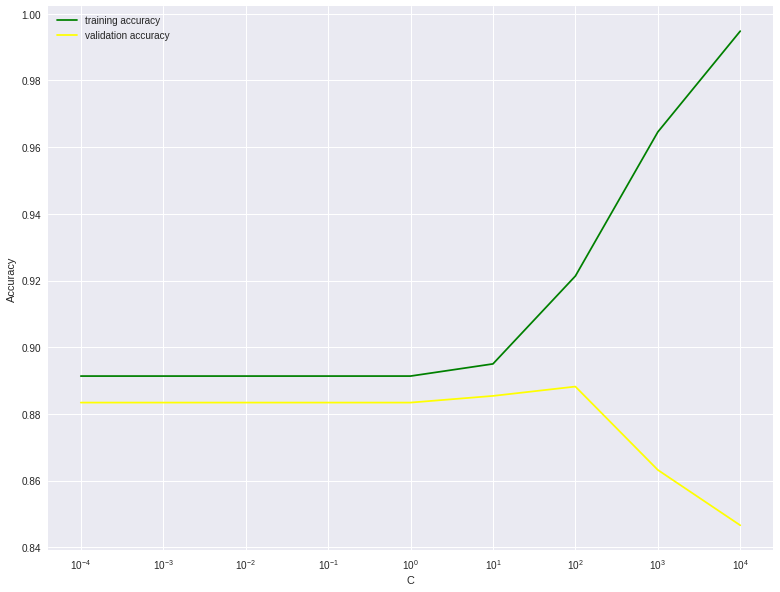

In [100]:
import pylab
plt.figure(figsize=(13, 10))
neighbors_settings = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
plt.plot(neighbors_settings, tfidfw2v_lgr_train_score_list, label="training accuracy", color='green')
plt.plot(neighbors_settings, tfidfw2v_lgr_val_score_list, label="validation accuracy", color='yellow')
# plt.plot(neighbors_settings, auc_test, label="test accuracy", color='red')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.xscale('log')

plt.show()

In [101]:
tfidfw2v_svm_linear=SVC(C=best_c, kernel='rbf')
tfidfw2v_svm_linear.fit(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
f = CalibratedClassifierCV(base_estimator=bow_svm_linear)
f.fit(tfidfw2v_dict['X_train_tfidfw2v'], Y_train)
tfidfw2v_test_proba = f.predict_proba(tfidfw2v_dict['X_test_tfidfw2v'])
tfidfw2v_train_proba = f.predict_proba(tfidfw2v_dict['X_train_tfidfw2v'])
tfidfw2v_test_proba

array([[0.10412962, 0.89587038],
       [0.2323531 , 0.7676469 ],
       [0.05416867, 0.94583133],
       ...,
       [0.08060694, 0.91939306],
       [0.04606088, 0.95393912],
       [0.15819022, 0.84180978]])

In [102]:
tfidfw2v_fpr_train, tfidfw2v_tpr_train, _ = roc_curve(Y_train, tfidfw2v_train_proba[:, 1])
tfidfw2v_fpr_test, tfidfw2v_tpr_test, _ = roc_curve(Y_test, tfidfw2v_test_proba[:, 1])
tfidfw2v_test_auc = auc(tfidfw2v_fpr_test, tfidfw2v_tpr_test)
tfidfw2v_train_auc = auc(tfidfw2v_fpr_train, tfidfw2v_tpr_train)
print(tfidfw2v_test_auc)
print(tfidfw2v_train_auc)

0.7760070827799912
0.968807610477042


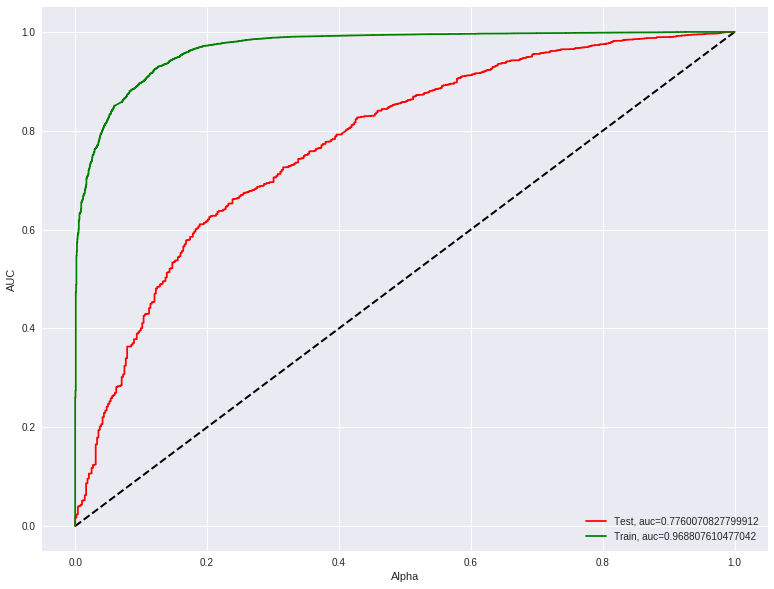

In [103]:
import pylab
plt.figure(figsize=(13, 10))
plt.plot([0,1], [0,1], color='black', lw=2, linestyle='--')
plt.plot(tfidfw2v_fpr_test, tfidfw2v_tpr_test, label="Test, auc="+str(tfidfw2v_test_auc), color = 'red')
plt.plot(tfidfw2v_fpr_train, tfidfw2v_tpr_train, label="Train, auc="+str(tfidfw2v_train_auc), color = 'green')

plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [0]:
tfidfw2v_test_conf = tfidfw2v_svm_linear.predict(tfidfw2v_dict['X_test_tfidfw2v'])
tfidfw2v_train_conf = tfidfw2v_svm_linear.predict(tfidfw2v_dict['X_train_tfidfw2v'])

In [105]:
from sklearn.metrics import classification_report, confusion_matrix
tfidfw2v_test_conf_matrix = confusion_matrix(Y_test, tfidfw2v_test_conf)
tfidfw2v_train_conf_matrix = confusion_matrix(Y_train, tfidfw2v_train_conf)
class_report = classification_report(Y_test, tfidfw2v_test_conf)
print(tfidfw2v_train_conf_matrix)
print(class_report)

[[  649  1524]
 [   49 17778]]
              precision    recall  f1-score   support

           0       0.59      0.14      0.22       482
           1       0.92      0.99      0.95      4518

   micro avg       0.91      0.91      0.91      5000
   macro avg       0.75      0.56      0.59      5000
weighted avg       0.88      0.91      0.88      5000



[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

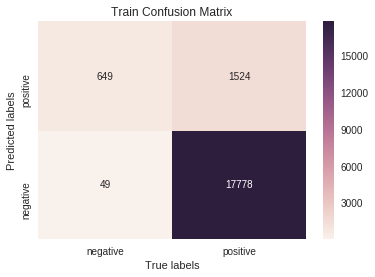

In [106]:
ax= plt.subplot()
sns.heatmap(tfidfw2v_train_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Train Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

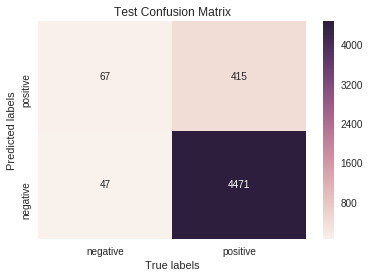

In [107]:
ax= plt.subplot()
sns.heatmap(tfidfw2v_test_conf_matrix, annot=True, ax = ax, fmt='g')

ax.set_ylabel('Predicted labels')
ax.set_xlabel('True labels')
ax.set_title('Test Confusion Matrix') 
ax.xaxis.set_ticklabels(['negative', 'positive']) 
ax.yaxis.set_ticklabels(['negative', 'positive'])

In [102]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Algorithm", "Vectorizer", "Train", "Test"]

x.add_row(["Linear SVM",  "BoW", 0.903, 0.904])
x.add_row(["Linear SVM", "Tf-idf", 0.764, 0.768])
x.add_row(["Linear SVM", "Avg-w2v", 0.921, 0.924])
x.add_row(["Linear SVM", "tfidf_w2v", 0.893, 0.895])
x.add_row(["RBF",  "BoW", 0.992, 0.954])
x.add_row(["RBF", "Tf-idf", 0.976, 0.903])
x.add_row(["RBF", "Avg-w2v", 0.936, 0.868])
x.add_row(["RBF", "tfidf_w2v", 0.968, 0.776])
print(x)

+------------+------------+-------+-------+
| Algorithm  | Vectorizer | Train |  Test |
+------------+------------+-------+-------+
| Linear SVM |    BoW     | 0.903 | 0.904 |
| Linear SVM |   Tf-idf   | 0.764 | 0.768 |
| Linear SVM |  Avg-w2v   | 0.921 | 0.924 |
| Linear SVM | tfidf_w2v  | 0.893 | 0.895 |
|    RBF     |    BoW     | 0.992 | 0.954 |
|    RBF     |   Tf-idf   | 0.976 | 0.903 |
|    RBF     |  Avg-w2v   | 0.936 | 0.868 |
|    RBF     | tfidf_w2v  | 0.968 | 0.776 |
+------------+------------+-------+-------+


Steps taken to increase accuracy: <br>
i. Summary and Text columns are appended in single column <br>
ii. length of words is taken from appended column and stacked with sparse matrix <br>

Observations: <br>
i. Accuracy increased around 2% for each vectorizer. <br>